In [ ]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

img= X_train

11490434/11490434 [==============================] - 0s 0us/step


# *Centroid*

In [ ]:
def get_block(images, num_blocks_x, num_blocks_y):

    rows, cols = images.shape[1:]

    block_size_rows = rows // num_blocks_x
    block_size_cols = cols // num_blocks_y

    images_blocks=[]

    # Slice the image matrix into blocks

    for image in (images):
        sliced_blocks = []
        for i in range(num_blocks_x):
            for j in range(num_blocks_y):
             block = image[i * block_size_rows: (i + 1) * block_size_rows, j * block_size_cols: (j + 1) * block_size_cols]
             sliced_blocks.append(block)

        images_blocks.append(sliced_blocks)
    images_blocks=np.array(images_blocks)

    return images_blocks

def X_bar(img):

 XY=[]
 for i in range (len(img)):
    feature_vector=[]
    for block in range(len(img[i])):
        x_bar=0
        y_bar=0
        denomenator=np.sum(img[i][block])

        numerator1=0
        for x in range(len(img[i][block])):
            for y in range (len(img[i][block][x])):
                numerator1=x*img[i][block][x][y]+numerator1

        numerator2=0
        for y in range(img.shape[3]):
            for x in range (img.shape[2]):
                numerator2=y*img[i][block][x][y]+numerator2

        if denomenator != 0:
           x_bar = numerator1 / denomenator
           y_bar = numerator2 / denomenator
        else:
           x_bar = 0
           y_bar = 0
        feature_vector.append(x_bar)
        feature_vector.append(y_bar)
    feature_vector=np.array(feature_vector)

    XY.append(feature_vector)


 XY=np.array(XY)
 return XY
num_blocks_x =4
num_blocks_y =4
X_train_block=get_block(X_train,num_blocks_x, num_blocks_y)
#X_test=get_block(X_test,num_blocks_x, num_blocks_y)
X_cent_train=X_bar(X_train_block)
#X_cent_test=X_bar(X_test)

# *Chain code*

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
def get_Boundary(img):
  from skimage.measure import find_contours
  contours = find_contours(img, 0.5)
  binary_contours = np.zeros_like(img, dtype=np.uint8)

  for contour in contours:
      contour = np.round(contour).astype(int)
      binary_contours[contour[:, 0], contour[:, 1]] = 1
  return binary_contours

def findChainCode(Boundary):
    sz = Boundary.shape
    sy, sx = np.where(Boundary == 1)
    startPt = [sy[0], sx[0]]
    currentPt = startPt
    #directions = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
    directions = np.array([[0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [1, 0], [1, 1]])
    dir = 0
    n=0
    chainCodeIndex = 0
    chainCode = []

    while True:
        for i in range(8):
            nextPt = currentPt + directions[dir]
            validPosn = 0
            #print("dir",currentPt)

            if (0 < nextPt[0] < sz[0]) and (0 < nextPt[1] < sz[1]):
                validPosn = 1

            if validPosn and Boundary[nextPt[0], nextPt[1]] == 1:
                chainCode.append(dir)
                chainCodeIndex += 1
                currentPt = nextPt
                #dir = dir - 3
                #print(currentPt)

                if dir < 0:
                    dir += 8
                break
            else:
                #print(currentPt)
                dir = dir + 1

                if dir >= 8:
                    dir = 0

        if np.array_equal(currentPt, startPt):
            break
                n=n+1
        if n>=600:
          return np.array(chainCode)

    return np.array(chainCode)

def first_difference(chain_code):
    # Calculate the first difference of the chain code
    first_diff = np.roll(chain_code, -1) - chain_code
    first_diff[first_diff <= -1] += 8
    # Move the last element to the beginning of the array
    first_diff = np.roll(first_diff, 1)

    return first_diff

def circular_difference(chain_code):
    # Calculate the circular difference after a minimum circular shift
    min_shift = min(chain_code)
    min_shift_index = np.where(chain_code == min_shift)[0][0]
    circular_diff = np.roll(chain_code, -min_shift_index)
    return circular_diff
def extract_chain_code_features(images):
    features = []
    for image in images:
        bound = get_Boundary(image)
        chain_code = findChainCode(bound)
        features.append(chain_code)
    return features
X_train_ = extract_chain_code_features(X_train)
X_test_ = extract_chain_code_features(X_test)
max_length = max(len(vec) for vec in X_train_)

# Pad or truncate feature vectors to ensure consistent length
#train_features = [vec + [0] * (max_length - len(vec)) for vec in X_train]
X_chain_train = [np.pad(vec, (0, max_length - len(vec)), mode='constant') for vec in X_train_]
# Convert to numpy array
X_chain_train = np.array(X_chain_train)

#max_length = max(len(vec) for vec in X_test)

# Pad or truncate feature vectors to ensure consistent length
X_chain_test = [np.pad(vec, (0, max_length - len(vec)), mode='constant') for vec in X_test_]
# Convert to numpy array
X_chain_test = np.array(X_chain_test)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.]]


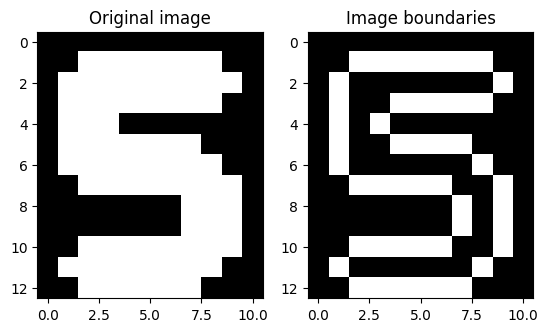

Chain Code: [0 0 0 0 0 0 7 5 4 4 4 4 5 7 0 0 0 7 7 6 6 6 5 5 4 4 4 4 4 3 1 0 0 0 0 1 2
 3 4 4 4 4 3 2 2 2 2 1]
First Difference: [7 0 0 0 0 0 7 6 7 0 0 0 1 2 1 0 0 7 0 7 0 0 7 0 7 0 0 0 0 7 6 7 0 0 0 1 1
 1 1 0 0 0 7 7 0 0 0 7]
Circular Difference after minimum circular shift: [0 0 0 0 0 7 6 7 0 0 0 1 2 1 0 0 7 0 7 0 0 7 0 7 0 0 0 0 7 6 7 0 0 0 1 1 1
 1 0 0 0 7 7 0 0 0 7 7]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def getImgBoundary(bw_img):
    sz = np.shape(bw_img)
    boundaryImg = np.zeros(sz)
    imgPadded = np.zeros((sz[0] + 2, sz[1] + 2))
    imgPadded[1:-1, 1:-1] = bw_img
    for i in range(1, sz[0] + 1):
        for j in range(1, sz[1] + 1):
            if imgPadded[i, j]:
                if not imgPadded[i - 1, j] or not imgPadded[i + 1, j] or not imgPadded[i, j - 1] or not imgPadded[
                    i, j + 1]:
                    boundaryImg[i - 1, j - 1] = 1
    return boundaryImg

img = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
                [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

boundaryImg = getImgBoundary(img)
print(boundaryImg)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(boundaryImg, cmap='gray')
axs[1].set_title('Image boundaries')
plt.show()

chCode, chMap = findChainCode(boundaryImg)

chMap -= 1
#chCode = 1  # 0 to 7 instead of 1 to 8

# Calculate first difference
first_diff = first_difference(chCode)

# Calculate circular difference
circular_diff = circular_difference(first_diff)

print("Chain Code:", chCode)

print("First Difference:", first_diff)
print("Circular Difference after minimum circular shift:", circular_diff)


chain_code [0 0 7 7 6 5 5 4 5 5 5 5 6 5 5 1 0 0 0 7 7 6 6 6 5 6 5 4 5 5 4 4 4 4 4 4 3
 3 3 2 2 2 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1]
first_diff_ [7 0 7 0 7 7 0 7 1 0 0 0 1 7 0 4 7 0 0 7 0 7 0 0 7 1 7 7 1 0 7 0 0 0 0 0 7
 0 0 7 0 0 7 1 7 0 0 0 0 1 7 0 0 0 0 0 0]
circular_difference [0 7 0 7 7 0 7 1 0 0 0 1 7 0 4 7 0 0 7 0 7 0 0 7 1 7 7 1 0 7 0 0 0 0 0 7 0
 0 7 0 0 7 1 7 0 0 0 0 1 7 0 0 0 0 0 0 7]


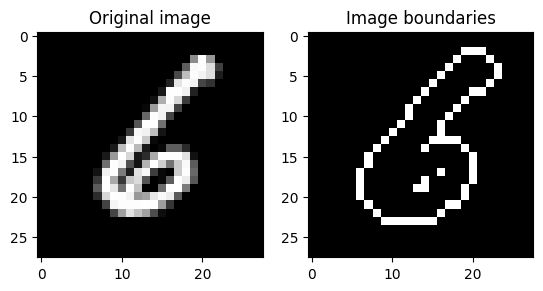

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

In [ ]:
bound = get_Boundary(X_train[3])
chainCode,_ = findChainCode(bound)
print("chain_code",chainCode)
first_diff_ = first_difference(chainCode)
print("first_diff_",first_diff_)
print("circular_difference",circular_difference(first_diff_))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(X_train[3], cmap='gray')
axs[0].set_title('Original image')
axs[1].imshow(bound, cmap='gray')
axs[1].set_title('Image boundaries')
plt.show()
print(bound)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_chain_train, y_train)

# Evaluate classifier
train_accuracy = accuracy_score(y_train, classifier.predict(X_chain_train))
test_accuracy = accuracy_score(y_test, classifier.predict(X_chain_test))
#test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

print("Training Accuracy:", train_accuracy)
print("test Accuracy:", test_accuracy)
#print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9947291666666667
test Accuracy: 0.9269166666666667


# KMeans without feature extraction

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define k-means function
def kmeans(X, k, max_iters=10000):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return centroids, labels

In [ ]:
x=X_train.reshape(-1,28*28)

In [ ]:
k = 10
centroids, labels = kmeans(x, k)

In [ ]:
# Assign cluster labels
cluster_labels = np.zeros_like(labels)
for i in range(k):
    mask = (labels == i)
    cluster_labels[mask] = np.bincount(y_train[mask]).argmax()

# Compute accuracy
accuracy = accuracy_score(y_train, cluster_labels)
print("Accuracy:", accuracy)


Accuracy: 0.5794166666666667


# *K means*
using centroid and chain code feature extraction methods


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Define k-means function
def kmeans(X, k, max_iters=10000):
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return centroids, labels

In [ ]:
k = 10
centroids_cent, labels_cent = kmeans(X_cent_train, k)
centroids_chain, labels_chain = kmeans(X_chain_train, k)

In [ ]:
# Count the number of samples in each class for the actual labels
unique, counts = np.unique(y_train, return_counts=True)
actual_counts = dict(zip(unique, counts))

# Count the number of samples in each cluster for the centroids features
unique, counts = np.unique(labels_cent, return_counts=True)
cent_counts = dict(zip(unique, counts))

# Count the number of samples in each cluster for the chain code features
unique, counts = np.unique(labels_chain, return_counts=True)
chain_counts = dict(zip(unique, counts))

# Compare the counts
for i in range(k):
    print("Class {}: Actual = {}, Centroids = {}, Chain = {}".format(i, actual_counts.get(i, 0), cent_counts.get(i, 0), chain_counts.get(i, 0)))


Class 0: Actual = 4748, Centroids = 3444, Chain = 3738
Class 1: Actual = 5420, Centroids = 3142, Chain = 3793
Class 2: Actual = 4784, Centroids = 2713, Chain = 4024
Class 3: Actual = 4912, Centroids = 13848, Chain = 4446
Class 4: Actual = 4666, Centroids = 4840, Chain = 8099
Class 5: Actual = 4317, Centroids = 2745, Chain = 4851
Class 6: Actual = 4741, Centroids = 3770, Chain = 4190
Class 7: Actual = 4966, Centroids = 2744, Chain = 5748
Class 8: Actual = 4691, Centroids = 7068, Chain = 8893
Class 9: Actual = 4755, Centroids = 3686, Chain = 218


In [ ]:
# Assuming you have the actual labels for the training data
actual_labels = y_train
# Count the number of samples in each class using actual labels
actual_counts = np.bincount(actual_labels)

# Count the number of samples in each class using k-means with centroids features
centroids_counts = np.bincount(labels_cent)

# Count the number of samples in each class using k-means with chain code features
chain_counts = np.bincount(labels_chain)

# Print the comparison results
for i in range(10):
    print("Class {}: Actual = {}, Centroids = {}, Chain = {}".format(i, actual_counts[i], centroids_counts[i], chain_counts[i]))

Class 0: Actual = 4748, Centroids = 3444, Chain = 3738
Class 1: Actual = 5420, Centroids = 3142, Chain = 3793
Class 2: Actual = 4784, Centroids = 2713, Chain = 4024
Class 3: Actual = 4912, Centroids = 13848, Chain = 4446
Class 4: Actual = 4666, Centroids = 4840, Chain = 8099
Class 5: Actual = 4317, Centroids = 2745, Chain = 4851
Class 6: Actual = 4741, Centroids = 3770, Chain = 4190
Class 7: Actual = 4966, Centroids = 2744, Chain = 5748
Class 8: Actual = 4691, Centroids = 7068, Chain = 8893
Class 9: Actual = 4755, Centroids = 3686, Chain = 218


In [ ]:
# Assign cluster labels
cluster_labels = np.zeros_like(labels_cent)
for i in range(k):
    mask = (labels_cent == i)
    cluster_labels[mask] = np.bincount(y_train[mask]).argmax()

# Compute accuracy
accuracy = accuracy_score(y_train, cluster_labels)
print("Accuracy:", accuracy)


Accuracy: 0.3631041666666667


In [ ]:
# Assign cluster labels
cluster_labels = np.zeros_like(labels_chain)
for i in range(k):
    mask = (labels_chain == i)
    cluster_labels[mask] = np.bincount(y_train[mask]).argmax()

# Compute accuracy
accuracy = accuracy_score(y_train, cluster_labels)
print("Accuracy:", accuracy)


Accuracy: 0.4402083333333333


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, labels_cent)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 395   23   78  359  858 1050   87  662  138 1098]
 [  16    7   10 1931  142    2    4    4 3300    4]
 [1363   78  688 1163  910  111  114   54   50  253]
 [ 956   24 1047 1787  676   93   55   72   43  159]
 [ 166  188  255 1033  255  677  369  211 1020  492]
 [ 142  656  137 1279 1081  378   82   89  312  161]
 [ 213   18  101 1443  165   47   12 1267  992  483]
 [  19 1108  226  729   35   63 2426   71  208   81]
 [ 142   49  147 2582  688  191   43  219  371  259]
 [  32  991   24 1542   30  133  578   95  634  696]]


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, labels_chain)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1704   35  493  649  111 1588   30    1   73   64]
 [  23    0 4786    5   10  504    1    2    3   86]
 [ 162  225   28  188  368  151  801   17 1951  893]
 [ 329  367   35  666    6  148 2243    0  863  255]
 [  35    8  126    4 1854  180    1    1  296 2161]
 [ 238 1712   61  198  244  278  479    0  760  347]
 [  74   21  211   11 1324  944    6  196  262 1692]
 [ 628  497   94 1437   37  356 1473    1  205  238]
 [1472  151  222 1095  243  813  254    0  287  154]
 [1899   90  231  759  160 1308   82    0  143   83]]


# *Use PCA*

In [ ]:
from sklearn.decomposition import PCA
pca_cent = PCA(n_components=2)
X_cent_train_pca = pca_cent.fit_transform(X_cent_train)

# Apply PCA to chain code features
pca_chain = PCA(n_components=2)
X_chain_train_pca = pca_chain.fit_transform(X_chain_train)

In [ ]:
k = 10
centroids_cent, labels_cent = kmeans(X_cent_train_pca, k)
centroids_chain, labels_chain = kmeans(X_chain_train_pca, k)

In [ ]:
# Assign cluster labels
cluster_labels = np.zeros_like(labels_cent)
for i in range(k):
    mask = (labels_cent == i)
    cluster_labels[mask] = np.bincount(y_train[mask]).argmax()

# Compute accuracy
accuracy = accuracy_score(y_train, cluster_labels)
print("Accuracy:", accuracy)


Accuracy: 0.30075


In [ ]:
# Assign cluster labels
cluster_labels = np.zeros_like(labels_chain)
for i in range(k):
    mask = (labels_chain == i)
    cluster_labels[mask] = np.bincount(y_train[mask]).argmax()

# Compute accuracy
accuracy = accuracy_score(y_train, cluster_labels)
print("Accuracy:", accuracy)


Accuracy: 0.4130625


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, labels_cent)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 781  615   97 1331  205  180   19   44  831  645]
 [  27    0 3129    2 1892    7   34  175  145    9]
 [ 559  274   44  321  556  527  606  127  250 1520]
 [ 509  211   24  276 1158  708  771   62  142 1051]
 [ 478  863  716   46  419  333  437  381  964   29]
 [ 836  224  381  189  437  302   97  358  884  609]
 [ 909  367  877   47 1255  278  473   76  401   58]
 [ 175   58 1122    2  532   78  324 2109  558    8]
 [1149  122  331   79 1537  266  301  100  280  526]
 [ 588  550 1497   27 1025  128   91  211  594   44]]


In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, labels_chain)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1704   35  493  649  111 1588   30    1   73   64]
 [  23    0 4786    5   10  504    1    2    3   86]
 [ 162  225   28  188  368  151  801   17 1951  893]
 [ 329  367   35  666    6  148 2243    0  863  255]
 [  35    8  126    4 1854  180    1    1  296 2161]
 [ 238 1712   61  198  244  278  479    0  760  347]
 [  74   21  211   11 1324  944    6  196  262 1692]
 [ 628  497   94 1437   37  356 1473    1  205  238]
 [1472  151  222 1095  243  813  254    0  287  154]
 [1899   90  231  759  160 1308   82    0  143   83]]
